In [88]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import inv
from scipy import linalg
from matplotlib import cm
import numpy.polynomial
from scipy.interpolate import lagrange

In [89]:
class CnkNcsn():
    """
        Crank-Nicolson Method for Heat Equation du/dt= d/dx du/dx, u(D)=bc, where D is the boundary.

        Class: CnkNcsn
        Attributes: 
            Domainx: list [x0,xn] defines range of x
            Domaint: int defines length of time to analyze
            GridSpacing: List [dx,dt] defines interpolation spacing
            InitialFunction: initial condition function
            BoundaryFunction: Adds to homogenous solution to include boundary conditions
    """

    def __init__(self, Domainx, Domaint, GridSpacing):
        self.Domainx = Domainx
        self.Domaint = Domaint
        self.GridSpacing = GridSpacing
        self.numtimesteps = int(Domaint/GridSpacing[1])
        self.t = np.arange(0, self.Domaint, self.GridSpacing[1])
        self.nx = int((Domainx[1]-Domainx[0]) / GridSpacing[0] +1)
        self.InitialFunction = 0
        self.BoundaryFunction = 0
        self.x = 0
        self.ic = 0
        self.bc = 0
        self.alpha = 0.5
        self.diagonals = 0 
        self.A = 0
        self.Ainv = 0
        self.solution = 0


    def interpolatex(self):
        """
            build grid from GridDomain_ and GridSpacing and store in self.Grid
        """
        self.x = np.linspace(self.Domainx[0], self.Domainx[1], self.nx)

    
    def evaluate_ic(self):
        """
            Evaluate the initial condition function on the grid points
        """
        self.ic = self.InitialFunction(self.x)  

    
    def evaluate_boundary(self):
        """
            Evaluate the bc on the grid points
        """
        self.bc = self.BoundaryFunction(self.x)


    def matrixify(self):
        """
            Build tridiagonal matrix with standard template
        """
        self.diagonals = [2*(1+self.alpha)*np.ones(self.nx), -self.alpha*np.ones(self.nx),-self.alpha*np.ones(self.nx)]
        self.A=diags(self.diagonals,[0, -1, 1]).toarray()
        self.A[self.nx-1][self.nx-1]=1
        self.A[0][0]=1


    def evaluate_conditions(self):
        """
            Interpolate x, build tri-diagonal matrix, evaluate initial and boundary conditions on grid
        """
        self.interpolatex()
        self.matrixify()

        if (self.BoundaryFunction !=0):
            self.evaluate_boundary()

        if (self.InitialFunction !=0):
            self.evaluate_ic()

        # make grid to fill with solutions at timesteps
        self.solution = np.zeros((self.numtimesteps, self.nx))

        # fill t=0 with ic
        self.solution[0] = self.ic

    
    def solve(self):
        """
            Solve the system by iteratively solving Au = b
        """
        self.evaluate_conditions()

        nx = self.nx
        alpha = self.alpha

        # self.Ainv = inv(self.A)

        for m in range(1,self.numtimesteps):
            u = self.solution[m-1]
            b=np.zeros(nx)
            b[1:-1] = alpha*u[0:nx-2] + 2*(1-alpha)*u[1:nx-1]+alpha*u[2:nx]
            # self.solution[m] = self.Ainv*b
            self.solution[m] = spsolve(self.A,b)

        if (self.BoundaryFunction !=0):
            self.add_boundary()


    def add_boundary(self):
        """
            After solving the system we add a boundary function to set boundary conditions
        """
        for i in range(len(self.solution)):
            self.solution[i] = self.solution[i] + self.bc


    def show_contours(self):
        """
            Plot solution at different time steps
        """
        timesteps = np.geomspace(1,self.numtimesteps-1, 10, dtype=int)

        labl = "t=0"
        plt.plot(self.x,self.solution[0], label=labl)
        
        for i in timesteps:
            labl = "t=" + str(self.t[i])[:4]
            plt.plot(self.x,self.solution[i], label=labl)

        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.title(r'$u(x,t)$',fontsize=20,y=1.08)
        plt.legend()
        plt.show()


    def show_density(self):
        """
            Plot all timesteps in domain on density plot
        """
        normf = mpl.colors.Normalize(vmin=2, vmax=6)
        plt.imshow(self.solution, aspect='auto', norm=normf)
        plt.title(r'$u(x,t)$',fontsize=20,y=1.08)
        plt.xlabel(r"x")
        plt.ylabel(r"t")
        plt.colorbar()

        plt.show()


    def show_surface(self):
        fig, ax = plt.subplots(subplot_kw={"projection":"3d"})
        normf = mpl.colors.Normalize(vmin=-2, vmax=2)
        grid = np.meshgrid(self.x,self.t)
        surf = ax.plot_surface(grid[0],
                            grid[1],
                            self.solution,
                            cmap=cm.coolwarm)
                            # norm=normf)

        fig.colorbar(surf)
        # ax.set_aspect('equal')
        ax.set_xlabel("x")
        ax.set_ylabel("t")
        ax.set_zlabel("u")
        plt.title(r'$u(x,t)$',fontsize=20,y=1.08)

        plt.show()     


        


In [265]:
class WtdResGssChbsv():
    """
        Gauss-ChebyshevLobatto collocation method on a Gauss-Chebyshev-Lobatto grid
        for Heat Equation du/dt= d/dx du/dx, u(D)=bc, where D is the boundary.

        Class: CnkNcsn
        Attributes: 
            Domainx: list [x0,xn] defines range of x
            Domaint: int defines length of time to analyze
            NumGridPoints: defines number of interpolation points in x
            TimeStepSize: size of timestep
            InitialFunction: initial condition function
            BoundaryFunction: Adds to homogenous solution to include boundary conditions
    """

    def __init__(self, Domainx, Domaint, NumGridPoints, TimeStepSize):
        self.Domainx = Domainx
        self.Domaint = Domaint
        self.NumGridPoints = NumGridPoints
        self.numtimesteps = int(Domaint/TimeStepSize)
        self.t = np.arange(0, self.Domaint, TimeStepSize)
        self.InitialFunction = 0
        self.BoundaryFunction = 0
        self.polynomials = 0
        self.nx = 0
        self.x = 0
        self.ic = 0
        self.bc = 0
        self.alpha = 0.5
        self.plotpoints = 200
        self.D = 0
        self.solution = 0


    def interpolatex(self):
        """
            build Gauss-Chebyshev-Lobatto grid
        """
        self.x = np.array([np.cos(k*np.pi / self.NumGridPoints) for k in range(0,self.NumGridPoints+1)])   


    def show_grid(self):
        plt.scatter(self.x,np.zeros(self.NumGridPoints+1), marker='.')
        plt.show()


    def construct_chbsv(self):
        """
            Build numgridpoints number of polynomials
        """
        self.polynomials = np.zeros((self.NumGridPoints, self.NumGridPoints))
        for i in range(self.NumGridPoints):
            self.polynomials[i] = numpy.polynomial.Chebyshev.basis(i).convert(kind=numpy.polynomial.Polynomial).coef


    def lagrange_interp_gcl(p, j, N):
        """
            Build j'th lagrange polynomial for gauss-chebyshev-lobatto grid with N points on list p
        """
        dj = 1

        if j == 0 or j == N:
            dj = 2

        poly = (((-1)**(N+j+1) * np.sqrt( 1-p**2 ) ) / ( dj * N**2 * (p-x[j])) ) * np.sin( N * np.arccos( p ) )

        return poly

    
    def evaluate_ic(self):
        """
            Evaluate the initial condition function on the grid points
        """
        self.ic = self.InitialFunction(self.x)  

    
    def evaluate_boundary(self):
        """
            Evaluate the bc on the grid points
        """
        self.bc = self.BoundaryFunction(self.x)


    def matrixify(self):
        """
            Build D2 matrix with template from course note 7 eq 109
        """
        x = self.x
        N = self.NumGridPoints
        self.D = np.zeros((N+1,N+1))

        # build helper functions
        def case1(i, j, dj):
            return ( ((-1)**(i+j) / dj) * ( x[i]**2 + x[i]*x[j] - 2 ) / ( (1 - x[i]**2) * (x[i]-x[j])**2 ) )
            
        def case2(i, j, dj):
            return ( - (((N)**2 - 1) * (1 - x[i]**2) + 3) / (3*(1-x[i]**2)**2) )
        
        def case3(i, j, dj):
            return ( ( (2*(-1)**(j)) / (3*dj) ) * ( ( (2* N**2 +1)*(1-x[j]) - 6) / ( (1-x[j])**2 ) ) )
        
        def case4(i, j, dj):
            return (((2*(-1)**(N+j))/(3*dj))*(((2* N**2 + 1)*(1+x[j])-6)/(1+x[j])**2))
        

        # set inside
        for i in range(1,N): # not including endpoints
            for j in range(0,N+1): # including endpoints
                if j!=i:
                    if j==0 or j==N:
                        self.D[i][j] = case1(i,j,2)
                    else:
                        self.D[i][j] = case1(i,j,1)


        # set inner diagonals
        for i in range(1,N):
            self.D[i][i] = case2(i,i,1)

        # set top row
        self.D[0][N] = case3(0, N, 2)
        for j in range(1,N):
            self.D[0][j] = case3(0,j,1)
        
        # set bottom row
        self.D[N][0] = case4(N, 0, 2)
        for j in range(1,N):
            self.D[N][j] = case4(N, j, 1)

        # set endpoints
        self.D[0][0] = ((N**4 -1)/15)
        self.D[N][N] = ((N**4 -1)/15)

        self.x = -self.x

        
    def evaluate_conditions(self):
        """
            Interpolate x, build D matrix, evaluate initial and boundary conditions on grid
        """
        self.interpolatex()
        self.matrixify()

        if (self.BoundaryFunction !=0):
            self.evaluate_boundary()

        if (self.InitialFunction !=0):
            self.evaluate_ic()

        # make grid to fill with solutions at timesteps
        self.solution = np.zeros((self.numtimesteps, self.NumGridPoints+1))

        # fill t=0 with ic
        self.solution[0] = self.ic


    def solve(self):
        """
            Solve the system by iteratively solving Du = b
        """
        self.evaluate_conditions()

        nx = self.NumGridPoints+1
        alpha = self.alpha
        dt = self.Domaint/self.numtimesteps

        self.D[0][:] = 0
        self.D[-1][:] = 0

        I = np.eye(nx)
        A = (I + (alpha*dt/2) * self.D)
        Ainv =  linalg.inv(I - (alpha*dt/2) * self.D)

        uk = np.zeros(nx)

        for m in range(1,self.numtimesteps):

            uk = self.solution[m-1]
            Auk = A @ uk

            self.solution[m] = Ainv @ Auk

        if (self.BoundaryFunction !=0):
            self.add_boundary()
        

    def add_boundary(self):
        """
            After solving the system we add a boundary function to set boundary conditions
        """
        for i in range(len(self.solution)):
            self.solution[i] = self.solution[i] + self.bc


    def show_contours(self):
        """
            Plot solution at different time steps
        """
        timesteps = np.geomspace(1,self.numtimesteps-1, 10, dtype=int)

        labl = "t=0"
        plt.plot(self.x,self.solution[0], label=labl)
        
        for i in timesteps:
            labl = "t=" + str(self.t[i])[:4]
            plt.plot(self.x,self.solution[i], label=labl)

        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.title(r'$u(x,t)$',fontsize=20,y=1.08)
        plt.legend()
        plt.show()


    def show_density(self):
        """
            Plot all timesteps in domain on density plot
        """
        normf = mpl.colors.Normalize(vmin=2, vmax=6)
        plt.imshow(self.solution, aspect='auto', norm=normf)
        plt.title(r'$u(x,t)$',fontsize=20,y=1.08)
        plt.xlabel(r"x")
        plt.ylabel(r"t")
        plt.colorbar()
        plt.show()


    def show_surface(self):
        fig, ax = plt.subplots(subplot_kw={"projection":"3d"})
        normf = mpl.colors.Normalize(vmin=-2, vmax=2)
        grid = np.meshgrid(self.x,self.t)
        surf = ax.plot_surface(grid[0],
                            grid[1],
                            self.solution,
                            cmap=cm.coolwarm)
                            # norm=normf)

        fig.colorbar(surf)
        # ax.set_aspect('equal')
        ax.set_xlabel("x")
        ax.set_ylabel("t")
        ax.set_zlabel("u")
        plt.title(r'$u(x,t)$',fontsize=20,y=1.08)

        plt.show()     


/Users/alynmusselman/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


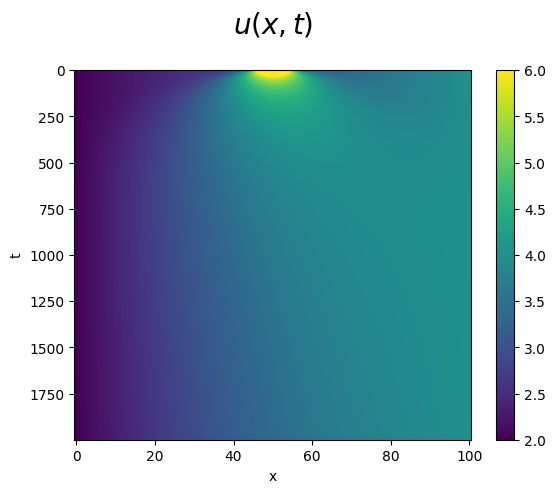

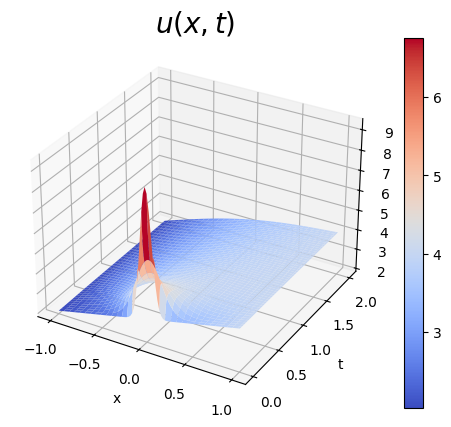

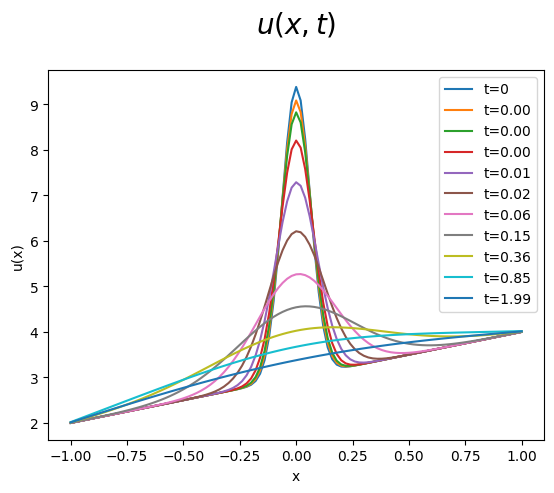

AttributeError: 'CnkNcsn' object has no attribute 'show_grid'

In [267]:
sys = CnkNcsn(
    [-1,1],
    2,
    [.02,.001]
)

def icfun(x):
    sigma = 1/16
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*(x/sigma)**2)


def bcfun(x):
    return x+3

sys.InitialFunction = icfun
sys.BoundaryFunction = bcfun

sys.solve()

sys.show_density()
sys.show_surface()
sys.show_contours()
sys.show_grid()

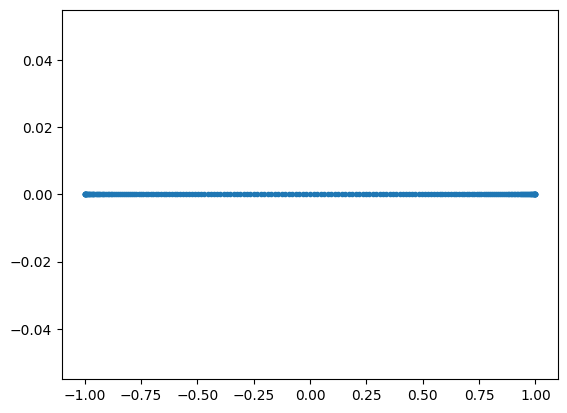

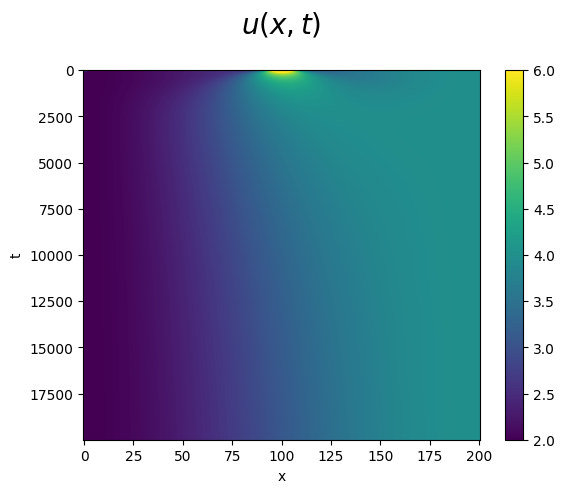

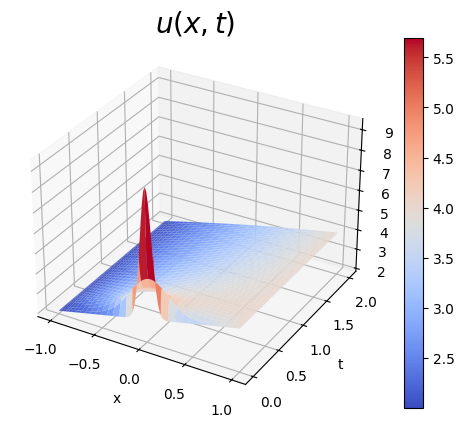

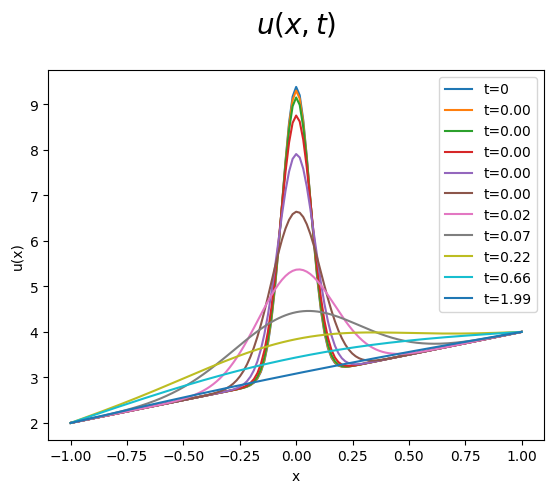

In [266]:
sys = WtdResGssChbsv(
    [-1,1],
    2,
    200,
    .0001
)

def icfun(x):
    sigma = 1/16
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*(x/sigma)**2)


def bcfun(x):
    return x+3

sys.InitialFunction = icfun
sys.BoundaryFunction = bcfun

# sys.evaluate_conditions()

sys.solve()

sys.show_grid()
plt.plot(sys.x, sys.solution[0])
sys.show_density()
sys.show_surface()
sys.show_contours()

In [ ]:
def analytic(x):
    return 